Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV] END clf__et__max_depth=30, clf__et__min_samples_leaf=4, clf__et__n_estimators=1260, clf__log_reg__C=0.0009384115043597787, clf__mlp__activation=tanh, clf__mlp__alpha=9.846738873614567e-05, clf__mlp__hidden_layer_sizes=(128,), clf__mlp__learning_rate_init=0.00026364803038431676, clf__rf__max_depth=35, clf__rf__min_samples_leaf=5, clf__rf__n_estimators=1523, clf__xgb__colsample_bytree=0.48572009075316447, clf__xgb__gamma=3.9053308376931173, clf__xgb__learning_rate=0.00015709049220124748, clf__xgb__max_depth=10, clf__xgb__n_estimators=1205, clf__xgb__subsample=0.4004672595046086; total time=  13.6s
[CV] END clf__et__max_depth=30, clf__et__min_samples_leaf=4, clf__et__n_estimators=1260, clf__log_reg__C=0.0009384115043597787, clf__mlp__activation=tanh, clf__mlp__alpha=9.846738873614567e-05, clf__mlp__hidden_layer_sizes=(128,), clf__mlp__learning_rate_init=0.00026364803038431676, clf__rf__max_depth=35, clf__rf__min_samples_

/home/morgan-cooper/miniconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END clf__et__max_depth=20, clf__et__min_samples_leaf=3, clf__et__n_estimators=1046, clf__log_reg__C=0.0008015922222732091, clf__mlp__activation=relu, clf__mlp__alpha=1.1649969967638899e-07, clf__mlp__hidden_layer_sizes=(64,), clf__mlp__learning_rate_init=0.04038423798071561, clf__rf__max_depth=5, clf__rf__min_samples_leaf=2, clf__rf__n_estimators=1176, clf__xgb__colsample_bytree=0.40957975133212854, clf__xgb__gamma=1.385362953732894, clf__xgb__learning_rate=0.000688770869227248, clf__xgb__max_depth=14, clf__xgb__n_estimators=908, clf__xgb__subsample=0.8999169470416986; total time=  16.5s
[CV] END clf__et__max_depth=20, clf__et__min_samples_leaf=3, clf__et__n_estimators=1046, clf__log_reg__C=0.0008015922222732091, clf__mlp__activation=relu, clf__mlp__alpha=1.1649969967638899e-07, clf__mlp__hidden_layer_sizes=(64,), clf__mlp__learning_rate_init=0.04038423798071561, clf__rf__max_depth=5, clf__rf__min_samples_leaf=2, clf__rf__n_estimators=1176, clf__xgb__colsample_bytree=0.40957975133

Searching optimal weights: 100%|██████████| 15625/15625 [00:50<00:00, 306.56it/s]



== Optimized Weights ==
Best Weights: (3, 1, 3, 2, 3, 3)
Combined AUC/Precision Score: 0.5123

== Weighted Ensemble — TEST Evaluation ==
Accuracy:  0.3158
AUC (OvR): 0.6863
Precision: 0.3383

Classification Report:
              precision    recall  f1-score     support
0              0.318841  0.458333  0.376068   48.000000
1              0.115385  0.096774  0.105263   31.000000
2              0.333333  0.066667  0.111111   15.000000
3              0.265060  0.360656  0.305556   61.000000
4              0.230769  0.200000  0.214286   15.000000
5              0.352941  0.410256  0.379447  117.000000
6              0.083333  0.181818  0.114286   11.000000
7              0.166667  0.173913  0.170213   46.000000
8              0.200000  0.058824  0.090909   17.000000
9              0.528736  0.345865  0.418182  133.000000
accuracy       0.315789  0.315789  0.315789    0.315789
macro avg      0.259506  0.235311  0.228532  494.000000
weighted avg   0.338281  0.315789  0.314737  494.000000


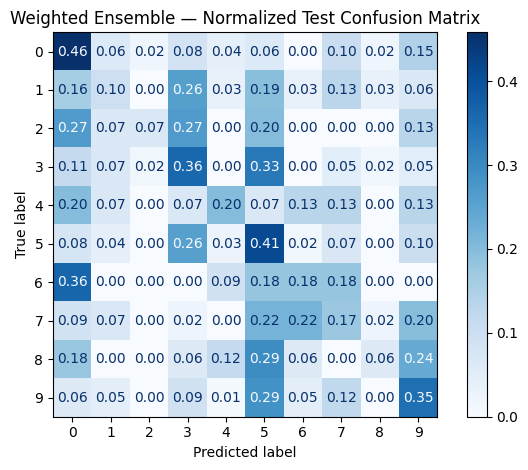


== Weighted Ensemble — Confidence Decile Table ==
       Top %  Accuracy  Avg Confidence
0     Top 5%     0.625           0.461
1    Top 10%     0.551           0.419
2    Top 15%     0.473           0.395
3    Top 20%     0.439           0.379
4    Top 25%     0.415           0.366
5    Top 30%     0.385           0.355
6    Top 35%     0.360           0.346
7    Top 40%     0.345           0.337
8    Top 45%     0.351           0.329
9    Top 50%     0.348           0.322
10   Top 55%     0.351           0.316
11   Top 60%     0.351           0.310
12   Top 65%     0.349           0.305
13   Top 70%     0.354           0.299
14   Top 75%     0.343           0.294
15   Top 80%     0.339           0.289
16   Top 85%     0.334           0.284
17   Top 90%     0.322           0.279
18   Top 95%     0.318           0.274
19  Top 100%     0.316           0.268


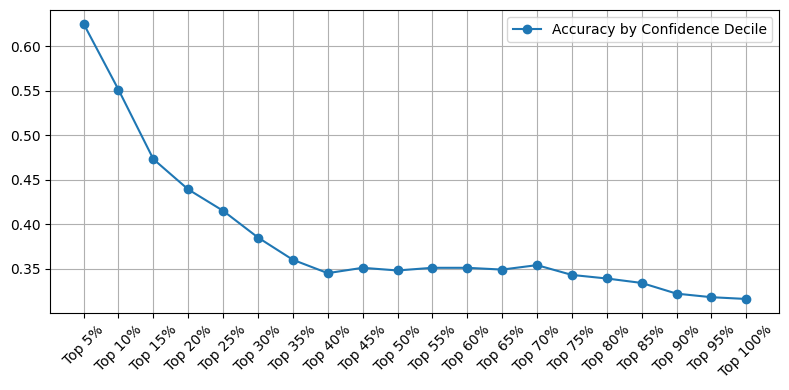

In [1]:
# ==============================================================
# Ultra-Robust Ensemble Regime Classification Pipeline — Unified
# ==============================================================

import itertools
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import (
    VotingClassifier, RandomForestClassifier, ExtraTreesClassifier
)
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    classification_report, accuracy_score,
    roc_auc_score, precision_score,
    ConfusionMatrixDisplay, f1_score
)
from scipy.stats import randint, uniform, loguniform

# ==============================================================
# 1. Load & Prepare Data
# ==============================================================

train_df = pd.read_csv("../data/generated_data/train.csv")
test_df  = pd.read_csv("../data/generated_data/test.csv")

drop_cols = ["date"]
train_df = train_df.select_dtypes(include=np.number).drop(columns=drop_cols, errors="ignore")
test_df  = test_df.select_dtypes(include=np.number).drop(columns=drop_cols, errors="ignore")

train_df["regime_t+3"] = train_df["regime"].shift(-3)
test_df["regime_t+3"]  = test_df["regime"].shift(-3)

train_df = train_df.drop(columns=["regime"]).dropna(subset=["regime_t+3"])
test_df  = test_df.drop(columns=["regime"]).dropna(subset=["regime_t+3"])

X_train = train_df.drop(columns=["regime_t+3"])
y_train = train_df["regime_t+3"].astype(int) - 1
X_test  = test_df.drop(columns=["regime_t+3"])
y_test  = test_df["regime_t+3"].astype(int) - 1

scaler = RobustScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# ==============================================================
# 2. Define Base Models
# ==============================================================

xgb = XGBClassifier(eval_metric="mlogloss", n_jobs=1, random_state=42)
rf  = RandomForestClassifier(random_state=42)
et  = ExtraTreesClassifier(random_state=42)
mlp = MLPClassifier(max_iter=50000, random_state=42)
# svc = SVC(probability=True, random_state=42)
log_reg = LogisticRegression(max_iter=50000, random_state=42)
lda = LinearDiscriminantAnalysis()
# knn = KNeighborsClassifier()

estimators_list = ["xgb", "rf", "et", "mlp", 
                #    "svc", 
                   "log_reg", "lda", 
                #    "knn"
                   ]

voting_clf = VotingClassifier(
    estimators=[
        ("xgb", xgb), ("rf", rf), ("et", et),
        ("mlp", mlp), 
        # ("svc", svc),
        ("log_reg", log_reg), ("lda", lda), 
        # ("knn", knn)
    ],
    voting="soft", n_jobs=4
)

pipeline = Pipeline([("clf", voting_clf)])

# ==============================================================
# 3. Robust Hyperparameter Search
# ==============================================================

param_distributions = {
    # XGBoost
    "clf__xgb__n_estimators": randint(400, 1600),
    "clf__xgb__max_depth": randint(3, 15),
    "clf__xgb__learning_rate": loguniform(1e-4, 0.3),
    "clf__xgb__subsample": uniform(0.4, 0.6),
    "clf__xgb__colsample_bytree": uniform(0.4, 0.6),
    "clf__xgb__gamma": uniform(0, 6),

    # Random Forest
    "clf__rf__n_estimators": randint(400, 1600),
    "clf__rf__max_depth": [None] + list(range(5, 50, 5)),
    "clf__rf__min_samples_leaf": randint(1, 8),

    # Extra Trees
    "clf__et__n_estimators": randint(400, 1600),
    "clf__et__max_depth": [None] + list(range(5, 50, 5)),
    "clf__et__min_samples_leaf": randint(1, 8),

    # MLP
    "clf__mlp__hidden_layer_sizes": [(64,), (128,), (256,), (512, 256), (256, 128), (128, 64)],
    "clf__mlp__activation": ["relu", "tanh"],
    "clf__mlp__alpha": loguniform(1e-7, 1e-2),
    "clf__mlp__learning_rate_init": loguniform(1e-4, 5e-2),

    # SVC
    # "clf__svc__C": loguniform(1e-2, 20),
    # "clf__svc__gamma": loguniform(1e-5, 1e-1),
    # "clf__svc__kernel": ["rbf", "poly", "sigmoid"],

    # Logistic Regression
    "clf__log_reg__C": loguniform(1e-4, 20),

    # KNN
    # "clf__knn__n_neighbors": randint(3, 30),
    # "clf__knn__weights": ["uniform", "distance"],
    # "clf__knn__p": [1, 2],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=200,
    scoring="roc_auc_ovr",
    cv=cv,
    n_jobs=4,
    verbose=2,
    random_state=42
)

search.fit(X_train_scaled, y_train)
print("\n== Best Ensemble Parameters ==")
print(search.best_params_)
print(f"Best CV AUC (OvR): {search.best_score_:.4f}")

best_model = search.best_estimator_

# ==============================================================
# 4. Fast Weight Optimization (AUC + Precision Focus)
# ==============================================================

proba_dict = {}
for name in estimators_list:
    model = best_model.named_steps["clf"].named_estimators_[name]
    proba_dict[name] = model.predict_proba(X_test_scaled)

all_combos = list(itertools.product([1, 2, 3, 4, 5], repeat=len(estimators_list)))
sampled_combos = random.sample(all_combos, int(len(all_combos) * 1))  # 0.05% of total

best_score, best_weights = -1, None

print(f"Testing {len(sampled_combos)} weight combinations...")

for w in tqdm(sampled_combos, desc="Searching optimal weights"):
    weighted_sum = np.zeros_like(list(proba_dict.values())[0])
    for weight, name in zip(w, estimators_list):
        weighted_sum += weight * proba_dict[name]
    y_pred_proba = weighted_sum / np.sum(w)
    y_pred = np.argmax(y_pred_proba, axis=1)

    auc = roc_auc_score(y_test, y_pred_proba, multi_class="ovr")
    precision = precision_score(y_test, y_pred, average="weighted", zero_division=0)
    combined = (auc + precision) / 2

    if combined > best_score:
        best_score, best_weights = combined, w

print("\n== Optimized Weights ==")
print(f"Best Weights: {best_weights}")
print(f"Combined AUC/Precision Score: {best_score:.4f}")

# ==============================================================
# 5. Evaluate Final Weighted Ensemble
# ==============================================================

weighted_sum = np.zeros_like(list(proba_dict.values())[0])
for weight, name in zip(best_weights, estimators_list):
    weighted_sum += weight * proba_dict[name]
y_pred_proba_final = weighted_sum / np.sum(best_weights)
y_pred_final = np.argmax(y_pred_proba_final, axis=1)

acc_final = accuracy_score(y_test, y_pred_final)
auc_final = roc_auc_score(y_test, y_pred_proba_final, multi_class="ovr")
precision_final = precision_score(y_test, y_pred_final, average="weighted", zero_division=0)

print("\n== Weighted Ensemble — TEST Evaluation ==")
print(f"Accuracy:  {acc_final:.4f}")
print(f"AUC (OvR): {auc_final:.4f}")
print(f"Precision: {precision_final:.4f}")
print("\nClassification Report:")
print(pd.DataFrame.from_dict(
    classification_report(y_test, y_pred_final, output_dict=True)
).transpose())

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_final, cmap="Blues",
    normalize="true", values_format=".2f"
)
plt.title("Weighted Ensemble — Normalized Test Confusion Matrix")
plt.tight_layout()
plt.show()

# ==============================================================
# 6. Confidence Decile Analysis
# ==============================================================

confidences = y_pred_proba_final.max(axis=1)
eval_df = pd.DataFrame({
    "true": y_test + 1,
    "pred": y_pred_final + 1,
    "conf": confidences
})
eval_df["correct"] = (eval_df["true"] == eval_df["pred"]).astype(int)
eval_df = eval_df.sort_values("conf", ascending=False).reset_index(drop=True)

decile_results = []
n = len(eval_df)
for d in range(5, 105, 5):
    cutoff = int((d / 100) * n)
    subset = eval_df.iloc[:cutoff]
    acc = subset["correct"].mean()
    avg_conf = subset["conf"].mean()
    decile_results.append({"Top %": f"Top {d}%", "Accuracy": round(acc, 3), "Avg Confidence": round(avg_conf, 3)})

decile_df = pd.DataFrame(decile_results)
print("\n== Weighted Ensemble — Confidence Decile Table ==")
print(decile_df)

plt.figure(figsize=(8, 4))
plt.plot(decile_df["Top %"], decile_df["Accuracy"], marker="o", label="Accuracy by Confidence Decile")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



In [2]:
# ==============================================================
# 7. Save Model, Scaler, Weights, and Results
# ==============================================================

import joblib
import json
from datetime import datetime
import os

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
save_dir = f"../models/ensemble_run_{timestamp}"
os.makedirs(save_dir, exist_ok=True)

# Save the trained pipeline (all base models inside)
joblib.dump(best_model, f"{save_dir}/ensemble_model.pkl")

# Save the scaler
joblib.dump(scaler, f"{save_dir}/scaler.pkl")

# Save optimized weights
with open(f"{save_dir}/best_weights.json", "w") as f:
    json.dump({"weights": best_weights, "combined_score": best_score}, f, indent=4)

# Save final test metrics
results = {
    "accuracy": round(acc_final, 4),
    "auc_ovr": round(auc_final, 4),
    "precision": round(precision_final, 4),
    "weights": best_weights,
    "combined_auc_precision": round(best_score, 4)
}
with open(f"{save_dir}/results_summary.json", "w") as f:
    json.dump(results, f, indent=4)

# Save decile table
decile_df.to_csv(f"{save_dir}/confidence_deciles.csv", index=False)

print(f"\n== Model and Results Saved in: {save_dir} ==")



== Model and Results Saved in: ../models/ensemble_run_20251015_075111 ==


Loaded model from ../models/ensemble_run_20251015_075111
Best Weights: [3, 1, 3, 2, 3, 3]

== Full Test Set — Classification Report ==
   precision    recall  f1-score  support
0   0.318841  0.458333  0.376068     48.0
1   0.115385  0.096774  0.105263     31.0
2   0.333333  0.066667  0.111111     15.0
3   0.265060  0.360656  0.305556     61.0
4   0.230769  0.200000  0.214286     15.0
5   0.352941  0.410256  0.379447    117.0
6   0.083333  0.181818  0.114286     11.0
7   0.166667  0.173913  0.170213     46.0
8   0.200000  0.058824  0.090909     17.0
9   0.528736  0.345865  0.418182    133.0


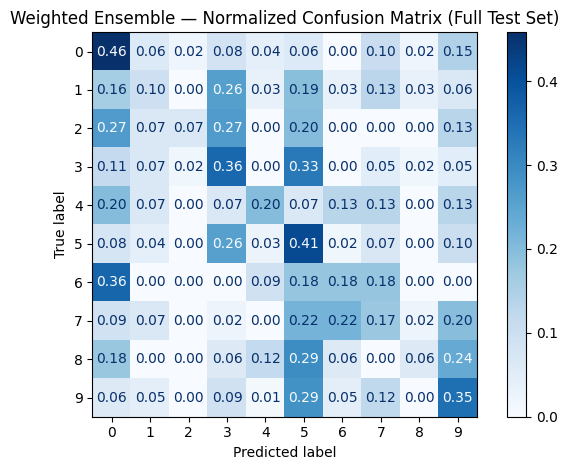

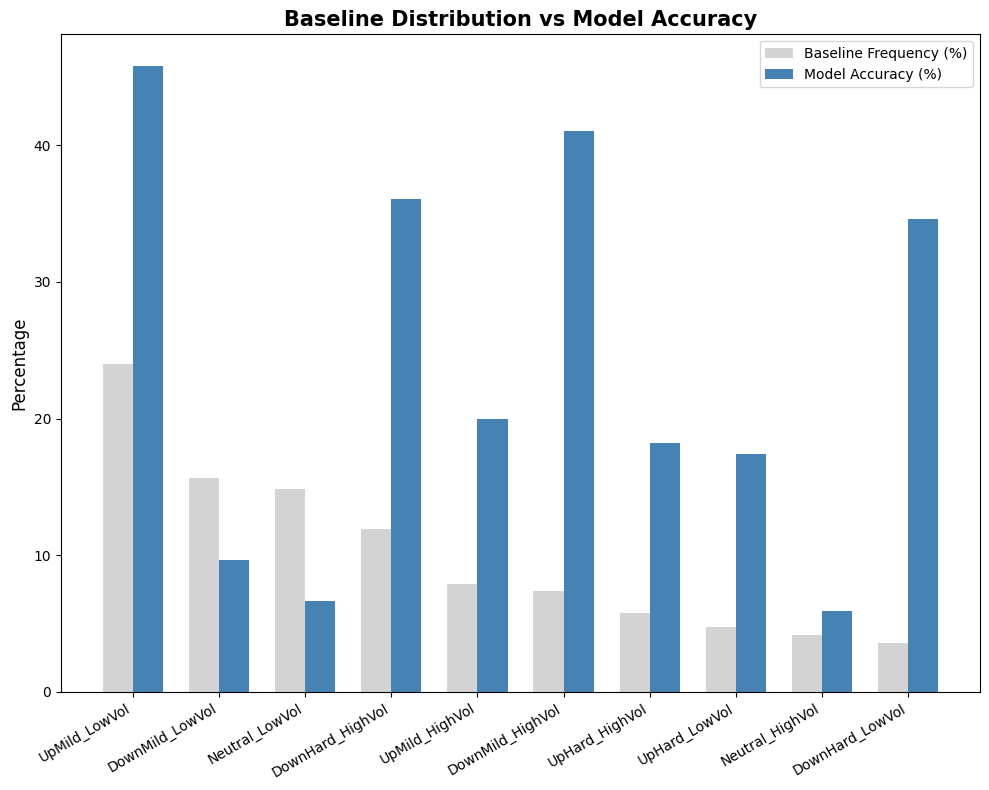

In [4]:
# ==============================================================
# Load Saved Model and Evaluate Top 20% Confidence Predictions
# ==============================================================

import joblib
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report,
    ConfusionMatrixDisplay,
    accuracy_score
)

# --------------------------------------------------------------
# 1. Load Model, Scaler, Weights, and Metadata
# --------------------------------------------------------------
MODEL_DIR = "../models/ensemble_run_20251015_075111"

model = joblib.load(f"{MODEL_DIR}/ensemble_model.pkl")
scaler = joblib.load(f"{MODEL_DIR}/scaler.pkl")

with open(f"{MODEL_DIR}/best_weights.json") as f:
    weights_info = json.load(f)
best_weights = weights_info["weights"]

print(f"Loaded model from {MODEL_DIR}")
print(f"Best Weights: {best_weights}")

# --------------------------------------------------------------
# 2. Reload Test Data
# --------------------------------------------------------------
test_df = pd.read_csv("../data/generated_data/test.csv")
drop_cols = ["date"]
test_df = test_df.select_dtypes(include=np.number).drop(columns=drop_cols, errors="ignore")
test_df["regime_t+3"] = test_df["regime"].shift(-3)
test_df = test_df.drop(columns=["regime"]).dropna(subset=["regime_t+3"])

X_test = test_df.drop(columns=["regime_t+3"])
y_test = test_df["regime_t+3"].astype(int) - 1
X_test_scaled = scaler.transform(X_test)

# --------------------------------------------------------------
# 3. Compute Weighted Predictions
# --------------------------------------------------------------
estimators_list = ["xgb", "rf", "et", "mlp", "log_reg", "lda"]

# Collect per-model probabilities
proba_dict = {
    name: model.named_steps["clf"].named_estimators_[name].predict_proba(X_test_scaled)
    for name in estimators_list
}

weighted_sum = np.zeros_like(list(proba_dict.values())[0])
for weight, name in zip(best_weights, estimators_list):
    weighted_sum += weight * proba_dict[name]

y_pred_proba = weighted_sum / np.sum(best_weights)
y_pred = np.argmax(y_pred_proba, axis=1)

# --------------------------------------------------------------
# 4. Classification Report and Confusion Matrix
# --------------------------------------------------------------
report = classification_report(y_test, y_pred, digits=4, output_dict=True)
report_df = pd.DataFrame(report).transpose()

print("\n== Full Test Set — Classification Report ==")
print(report_df[["precision", "recall", "f1-score", "support"]].head(10))

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    cmap="Blues",
    normalize="true",
    values_format=".2f"
)
plt.title("Weighted Ensemble — Normalized Confusion Matrix (Full Test Set)")
plt.tight_layout()
plt.show()

# --------------------------------------------------------------
# 5. Compare Accuracy vs Baseline Regime Frequency
# --------------------------------------------------------------
baseline_dist = pd.DataFrame({
    "regime": [
        "UpMild_LowVol", "DownMild_LowVol", "Neutral_LowVol", "DownHard_HighVol",
        "UpMild_HighVol", "DownMild_HighVol", "UpHard_HighVol", "UpHard_LowVol",
        "Neutral_HighVol", "DownHard_LowVol"
    ],
    "Percent": [24.03, 15.64, 14.86, 11.90, 7.91, 7.37, 5.80, 4.77, 4.17, 3.56]
})

# Compute normalized confusion for accuracy per class
cm = pd.crosstab(y_test, y_pred, normalize='index')
unique_classes = sorted(np.unique(y_test))

# Map regime labels adaptively
regime_labels = [
    "UpMild_LowVol", "DownMild_LowVol", "Neutral_LowVol", "DownHard_HighVol",
    "UpMild_HighVol", "DownMild_HighVol", "UpHard_HighVol", "UpHard_LowVol",
    "Neutral_HighVol", "DownHard_LowVol"
]
regime_labels = regime_labels[:len(unique_classes)]

# Reindex confusion to cover all detected classes
cm_full = cm.reindex(index=unique_classes, columns=unique_classes, fill_value=0)
class_acc = np.diag(cm_full.values)

model_perf = pd.DataFrame({
    "regime": regime_labels,
    "Model_Accuracy": class_acc * 100
})

# Align baseline (trim or pad)
baseline_trimmed = baseline_dist.head(len(model_perf))
compare_df = baseline_trimmed.merge(model_perf, on="regime", how="inner").sort_values("Percent", ascending=False)

# --------------------------------------------------------------
# 6. Plot Comparison
# --------------------------------------------------------------
plt.figure(figsize=(10,8))
bar_width = 0.35
x = np.arange(len(compare_df))

plt.bar(x - bar_width/2, compare_df["Percent"], width=bar_width, label="Baseline Frequency (%)", color="lightgray")
plt.bar(x + bar_width/2, compare_df["Model_Accuracy"], width=bar_width, label="Model Accuracy (%)", color="steelblue")

plt.xticks(x, compare_df["regime"], rotation=30, ha="right")
plt.ylabel("Percentage", fontsize=12)
plt.title("Baseline Distribution vs Model Accuracy", fontsize=15, weight="bold")
plt.legend()
plt.tight_layout()
plt.show()